In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns

In [2]:
symbol = 'MSFT'

**Driver Code**

In [3]:
def date_to_str(d):
    return f'{d.year}-{d.month}-{d.day}'

In [4]:
#get the historical prices for a stock
def get_ticker_data(symbol, start=None, end=None):
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(start=start, end=end, interval='1d').Close
        hist = hist[~hist.isna()]
        
        #day-to-day price difference
        diffs = hist.diff()
        hist = hist.reset_index()
        hist['price_change'] = diffs.values
        
        #cast datetime to date
        hist.Date = hist.Date.apply(lambda d: d.date())
    except:
        return None
    return hist.dropna()

In [5]:
#this class defines a stock trading strategy
class Strategy:
    def __init__(self, buy_condition: tuple, sell_condition: tuple):
        #check that both args are size 2 tuples
        if type(buy_condition) != tuple or len(buy_condition) != 2 or type(sell_condition) != tuple or len(sell_condition) != 2:
            raise Exception('buy_condition and sell_condition should each be size 2 tuples')
        buy_dir, buy_periods = buy_condition
        sell_dir, sell_periods = sell_condition
        
        #check that the buy and sell condition are increase or decrease
        if buy_dir not in ['decrease', 'increase'] or sell_dir not in ['decrease', 'increase']:
            raise Exception('first element of each tuple needs to be one of ["decrease", "increase"]')
            
        #check that the buy or sell periods are positve integers
        if type(buy_periods) != int or buy_periods <= 0 or type(sell_periods) != int or sell_periods <= 0:
            raise TypeError('second element of each tuple needs to be a positive integer')
            
        #set variables
        self.buy_dir = buy_dir
        self.buy_periods = buy_periods
        self.sell_dir = sell_dir
        self.sell_periods = sell_periods

In [6]:
def execute_strategy(history, strategy, debug=False):
    #start with $100 and no shares, remember inital value
    curr_value = 100
    initial_value = curr_value
    n_shares = 0
    
    #whether or not we're currently holding shares of the stock
    currently_holding = False
    
    #number of periods price has decreased or increased
    n_periods_dec = 0
    n_periods_inc = 0
    
    #backtest our strategy day-by-day
    for i,row in history.iterrows():
        
        #update periods of consecutive increasing or decreasing price
        if row.price_change < 0:
            n_periods_dec += 1
            n_periods_inc = 0
        elif row.price_change > 0:
            n_periods_inc += 1
            n_periods_dec = 0
        
        #try to buy only if we aren't currently holding shares
        if currently_holding == False:
            #buy only if the strategy's buy condition is met
            if (strategy.buy_dir == 'decrease' and n_periods_dec == strategy.buy_periods) or (strategy.buy_dir == 'increase' and n_periods_inc == strategy.buy_periods):
                #calulate number of shares we can buy 
                n_shares = curr_value / row.Close
                if debug:
                    print(f'bought {round(n_shares,2)} shares for ${round(row.Close, 2)} each on {row.Date}\n')
                #we now have no money and are holding shares, and reset periods of increasing or decreasing
                curr_value = 0
                n_periods_dec = 0
                n_periods_inc = 0
                currently_holding = True
        
                
        #try to sell only if we are currently holding shares
        if currently_holding == True:
            #sell only if the strategy's sell condition is met
            if (strategy.sell_dir == 'decrease' and n_periods_dec == strategy.sell_periods) or (strategy.sell_dir == 'increase' and n_periods_inc == strategy.sell_periods):
                #get value of shares now
                curr_value = row.Close * n_shares
                if debug:
                    print(f'sold {round(n_shares,2)} shares for ${round(row.Close, 2)} each on {row.Date}\n')
                #we now own no shares, and reset periods of increasing or decreasing
                n_shares = 0
                n_periods_dec = 0
                n_periods_inc = 0
                currently_holding = False
                
    #the final value is the max of money we have on hand and the money tied up in shares we currently own
    final_val = max(curr_value, row.Close*n_shares)
    
    #return the percent change from initial value
    return 100*(final_val / initial_value - 1)

In [7]:
strategies = dict()

for i in range(1,5):
    for j in range(1,5):
        s1 = Strategy(buy_condition=('increase', i), sell_condition=('increase', j)) #buy in when increased by i, sell when increased by j
        s2 = Strategy(buy_condition=('increase', i), sell_condition=('decrease', j)) 
        s3 = Strategy(buy_condition=('decrease', i), sell_condition=('increase', j)) 
        s4 = Strategy(buy_condition=('decrease', i), sell_condition=('decrease', j)) 
        strategies[f'bi${i}si${j}'] = s1
        strategies[f'bi${i}sd${j}'] = s2
        strategies[f'bd${i}si${j}'] = s3
        strategies[f'bd${i}sd${j}'] = s4

    

**Backtests**

In [8]:
#initializations
time_range = 30
all_dates = [date(2023,1,1) + timedelta(i) for i in range(365)]
history = get_ticker_data(symbol, start=date_to_str(all_dates[0]), end=date_to_str(all_dates[-1]))
print(history)

           Date       Close  price_change
1    2023-01-04  227.086456    -10.387894
2    2023-01-05  220.356110     -6.730347
3    2023-01-06  222.953079      2.596970
4    2023-01-09  225.123840      2.170761
5    2023-01-10  226.838638      1.714798
..          ...         ...           ...
245  2023-12-22  374.579987      1.039978
246  2023-12-26  374.660004      0.080017
247  2023-12-27  374.070007     -0.589996
248  2023-12-28  375.279999      1.209991
249  2023-12-29  376.040009      0.760010

[249 rows x 3 columns]


In [9]:
results = {k: [] for k in strategies.keys()}

for start_date in all_dates[:-time_range]:
    end_date = start_date + timedelta(days=time_range)
    history_lim = history[(history.Date >= start_date) & (history.Date <= end_date)]
    start_date = date_to_str(start_date)
    end_date = date_to_str(end_date)
    
    for name, strategy in strategies.items():
        return_pct = execute_strategy(history_lim, strategy, debug=False)
        results[name].append(return_pct)

Text(137.72222222222223, 0.5, 'Probability')

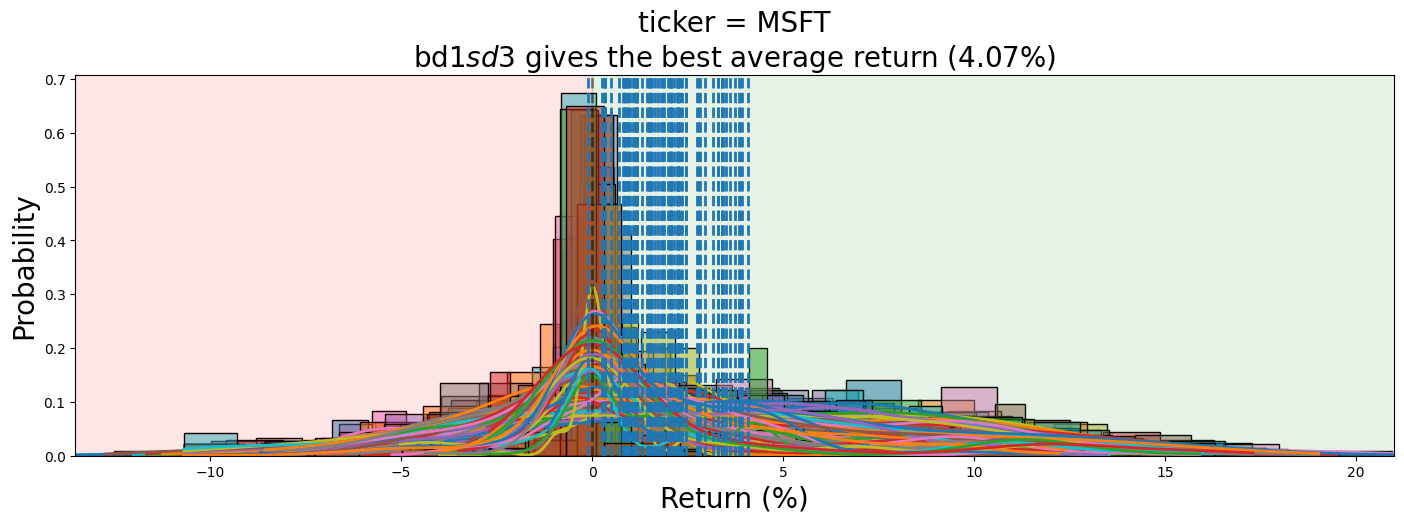

In [18]:
legend = []
colors = ['r', 'b', 'g', 'k', 'orange', 'pink', 'gray', 'purple']
plt.figure(figsize=(14,5))

idx = 0
min_return = 1000000
max_return = -1000000
max_y = -1000000

conclusion = f'ticker = {symbol}\nNo strategy is expected to give positve return'
best_avg_return = 0

for name, returns in results.items():
    distr_plot = sns.histplot(returns, kde=True, line_kws={'linewidth': 2}, stat='probability', bins=20)
    max_y = max(max_y, distr_plot.get_ybound()[1])
    idx += 1
    legend.append(name)
    min_return = min(min_return, np.min(returns))
    max_return = max(max_return, np.max(returns))
    
    avg_return = np.mean(returns)
    if avg_return > best_avg_return:
        conclusion = f'ticker = {symbol}\n{name} gives the best average return ({round(avg_return,2)}%)'
        best_avg_return = avg_return
# plt.legend(legend, fontsize=16)
plt.title(conclusion, fontsize=20)

#draw vertical lines
idx = 0
plt.fill_betweenx([0,1], -100, 0, color='r', alpha=0.1)
plt.fill_betweenx([0,1], 0, 100, color='g', alpha=0.1)
plt.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.5)
for name, returns in results.items():
    plt.axvline(np.mean(returns), linestyle='--', linewidth=2)
    idx += 1
    
plt.xlim(min_return, max_return)
plt.ylim(0, max_y)

plt.tight_layout()
plt.xlabel('Return (%)', fontsize=20)
plt.ylabel('Probability', fontsize=20)